# An Analysis of Covid-19 Deaths by Age and Income in São Paulo, Brazil

Read the [full analysis text here](https://medidasp.medium.com/an-analysis-of-covid-19-deaths-by-age-and-income-in-s%C3%A3o-paulo-brazil-be7fb28af0d2).

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
%matplotlib inline
import yaml
import geocoder.geocoder as geocoder
import jenkspy
import scipy

# SRAG Data (OpenDataSUS)

In [351]:
df_srag = pd.read_excel('data/sraghosp_18-05-2020.xlsx', converters={'NU_CEP': str})

In [ ]:
df_sp_covid = (
    df_srag[
        (df_srag.SG_UF == 'SP')
        & (df_srag.CLASSI_FIN == 5)
    ]
)
len(df_sp_covid)

In [ ]:
df_sp_deaths = df_sp_covid[df_sp_covid.EVOLUCAO == 2]
df_sp_deaths = df_sp_deaths[df_sp_deaths.NU_CEP.notna()]
df_sp_deaths.to_csv('exported/sp_deaths.csv', index=False)
len(df_sp_deaths)

### Geocode

In [ ]:
df_sp_deaths['cep'] = df_sp_deaths['NU_CEP'] + ' - SP'
df_sp_deaths.head().cep

In [ ]:
with open('secrets.yaml', 'r') as f:
    config = yaml.safe_load(f)

df_sp_deaths_geo = geocoder.geocode(df_sp_deaths[:], 'cep', 'geocoded/', config['google_maps_api_key'], use_slugify=True)
print('done')
df_sp_deaths_geo.to_csv('exported/sp_deaths_geo.csv', index=False)
# percentage geocoded
len(df_sp_deaths_geo[df_sp_deaths_geo.lat.notna()]) / len(df_sp_deaths)

# São Paulo Census Data

Obs: I've downloaded and preprocessed this data from IBGE Census 2010; the preprocessing was done in QGIS and is not included in this script, but the output data is.

In [6]:
sp_metro_set_cens_income_age = gpd.read_file('exported/extracted/sp_metro_set_cens_income_fix_age_4326.shp', encoding='utf-8')
sp_metro_set_cens_income_age['V005'] = sp_metro_set_cens_income_age['V005'].str.replace(',', '.').astype(float)

In [7]:
sp_metro_set_cens_income_age.NM_MUNICIP.unique()

array(['PRAIA GRANDE', 'ARUJÁ', 'BARUERI', 'BERTIOGA', 'BIRITIBA-MIRIM',
       'CAIEIRAS', 'CAJAMAR', 'CARAPICUÍBA', 'COTIA', 'EMBU', 'CUBATÃO',
       'DIADEMA', 'FRANCO DA ROCHA', 'GUARULHOS', 'EMBU-GUAÇU',
       'FERRAZ DE VASCONCELOS', 'FRANCISCO MORATO', 'GUARAREMA',
       'GUARUJÁ', 'ITAPECERICA DA SERRA', 'ITAQUAQUECETUBA', 'ITAPEVI',
       'JANDIRA', 'MAUÁ', 'MOGI DAS CRUZES', 'JUQUITIBA', 'MAIRIPORÃ',
       'OSASCO', 'PIRAPORA DO BOM JESUS', 'POÁ', 'RIBEIRÃO PIRES',
       'RIO GRANDE DA SERRA', 'SALESÓPOLIS', 'SANTO ANDRÉ',
       'SANTA ISABEL', 'SANTANA DE PARNAÍBA', 'SANTOS',
       'SÃO BERNARDO DO CAMPO', 'SÃO CAETANO DO SUL', 'SÃO PAULO',
       'SÃO LOURENÇO DA SERRA', 'SÃO VICENTE', 'SUZANO',
       'TABOÃO DA SERRA', 'VARGEM GRANDE PAULISTA'], dtype=object)

In [8]:
# remove cities that are not sp metro region
not_rmsp = ['BERTIOGA', 'SANTOS', 'GUARUJÁ', 'CUBATÃO', 'SÃO VICENTE', 'PRAIA GRANDE']
sp_metro_set_cens_income_age = sp_metro_set_cens_income_age[~(sp_metro_set_cens_income_age.NM_MUNICIP.isin(not_rmsp))]

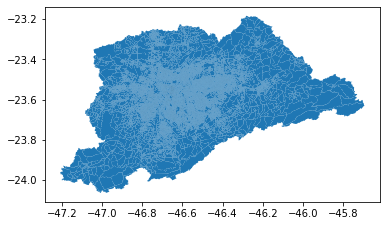

In [9]:
sp_metro_set_cens_income_age.plot()

In [10]:
# fix age fields
ages = [{'var': "i_V" + str(i).zfill(3), 'age': 1} for i in range(22, 35)]
starts_at = 35
ages += [{'var': "i_V" + str(i).zfill(3), 'age': i + 1 - starts_at} for i in range(starts_at, 134)]
ages.append({'var': 'i_V134', 'age': np.inf})

for age in ages:
    var_name = age['var']
    sp_metro_set_cens_income_age[var_name] = sp_metro_set_cens_income_age[var_name].str.replace('X', '0')
    sp_metro_set_cens_income_age[var_name] = pd.to_numeric(sp_metro_set_cens_income_age[var_name])
    sp_metro_set_cens_income_age[var_name] = sp_metro_set_cens_income_age[var_name].fillna(0)

In [11]:
# correct inflation to April 2020 Brazilian Reais, using IGP-M
# https://www3.bcb.gov.br/CALCIDADAO/publico/corrigirPorIndice.do?method=corrigirPorIndice
jan_2010_apr_2020_index = 1.92422990
sp_metro_set_cens_income_age['V005'] = sp_metro_set_cens_income_age['V005'] * jan_2010_apr_2020_index

### Binning age and income

In [12]:
age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, np.inf]
max_income = 14000
income_interval = 2000
income_bins = [x for x in range(0, max_income + 1, income_interval)] + [np.inf]
print(age_bins, income_bins)

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, inf] [0, 2000, 4000, 6000, 8000, 10000, 12000, 14000, inf]


In [13]:
breaks = jenkspy.jenks_breaks(sp_metro_set_cens_income_age['V005'], nb_class=7)
print(breaks)
pretty_breaks = [(round((b / 500), 0) * 500) for b in breaks]
pretty_breaks[-1] = np.inf
pretty_breaks

[0.0, 2999.0662375419997, 6362.446922051, 11430.772267155999, 18864.534186032, 35542.950782674, 79231.570820327, 141070.10454375]


/home/bernardoloureiro/anaconda3/envs/new-gis/lib/python3.6/site-packages/jenkspy/core.py:64: UserWarning: Invalid values encountered (NaN or Inf) were ignored
  warnings.warn('Invalid values encountered (NaN or Inf) were ignored')


[0.0, 3000.0, 6500.0, 11500.0, 19000.0, 35500.0, 79000.0, inf]

In [14]:
# we use the first classes of the jenks breaks 
income_bins = [0.0, 3000.0, 6500.0, 11500.0, 19000.0, np.inf]

In [15]:
age_labels = ['0-10', '11-20', '21-30', '31-40',
              '41-50', '51-60', '61-70', '71-80',
              '81-90', '91+']
income_labels = ['0-3.000', '3.001-6.500', '6.501-11.500',
                 '11.501-19.000', '19.001+']

### Generate population data per age and income

#### Warning: this might take a while

In [16]:
def aggregate_population():
    pop = []
    for index, row in sp_metro_set_cens_income_age[:].iterrows():
        for age in ages[:]:
            for p in range(int(row[age['var']])):
                pop.append([row['V005'], age['age']])
    print('---> done')

    pop_df = pd.DataFrame(pop, columns=['avg_income', 'age'])
    del(pop)
    pop_df['age_quant'] = pd.cut(pop_df['age'],
                                 bins=age_bins,
                                 include_lowest=True,
                                 labels=age_labels
                                )
    pop_df['income_quant'] = pd.cut(pop_df['avg_income'],
                                    bins=income_bins,
                                    include_lowest=True,
                                    labels=income_labels
                                   )
    result_pop = pop_df.groupby(['income_quant', 'age_quant']).size().unstack()
    del(pop_df)
    return result_pop

# only run below if you want to recalculate, this takes a while
# result_pop = aggregate_population()

### Save to file

In [171]:
result_pop.to_csv('exported/sp_rmsp_pop_income_age_bins_jenks_new_bins.csv')

### Read from file

In [16]:
result_pop = pd.read_csv('exported/sp_rmsp_pop_income_age_bins_jenks_new_bins.csv')
result_pop = result_pop.set_index('income_quant')
result_pop = result_pop.astype(float)

In [17]:
# total population in region, just a sanity check
'{:,}'.format(result_pop.sum().sum())

'19,906,064.0'

Text(50.99999999999999, 0.5, 'Average Income in Neighborhood of Residence')

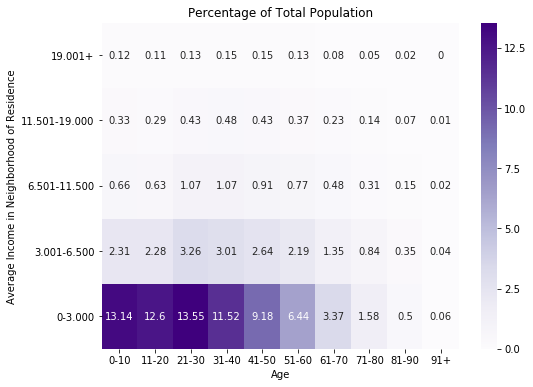

In [18]:
result_pop_pct = (result_pop / result_pop.sum().sum()).round(4).multiply(100)
fig, ax = plt.subplots(nrows=1, figsize=(8,6))

ax = sns.heatmap(result_pop_pct, annot=True, fmt="g", cmap='Purples', ax=ax)
ax.invert_yaxis()
ax.set_title('Percentage of Total Population')
ax.set_xlabel('Age')
ax.set_ylabel('Average Income in Neighborhood of Residence')

# Covid-19 Deaths (already geocoded)

In [19]:
# read data
df_sp_deaths_geo = pd.read_csv('exported/sp_deaths_geo.csv')

# add geometry
df_sp_deaths_geo = df_sp_deaths_geo.dropna(subset=["lng", "lat"])
geometry = [Point(xy) for xy in zip(df_sp_deaths_geo['lng'], df_sp_deaths_geo['lat'])]
df_sp_deaths_geo = gpd.GeoDataFrame(df_sp_deaths_geo, crs={'init': 'epsg:4326'}, geometry=geometry)

len(df_sp_deaths_geo)

/home/bernardoloureiro/anaconda3/envs/new-gis/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (134,136,137,138,140) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4743

In [20]:
places = df_sp_deaths_geo.groupby(['place_id']).size().sort_values(ascending=False)
places[:10]

place_id
ChIJ0WGkg4FEzpQRrlsz_whLqZs    119
ChIJrVgvRn1ZzpQRF3x74eJBUh4     74
ChIJZxlbDnnV0ZQRPLaxJx3FuA8      8
ChIJXd-DqZwDzpQReg24UixMyjI      7
ChIJKcsl23O1z5QRB0TSw49ITnM      7
ChIJmVHFWMBkkZQRsrhm11w4JCs      7
ChIJxVeB61-FzpQRXtYjvvBkffA      6
ChIJ91KTOyIm0JQRUaUXJV_ayWM      6
ChIJU00TxeNXzpQRYLLFm_mcGOU      6
ChIJN2Bp47RZzpQR-x9g0v8aSo0      5
dtype: int64

In [21]:
# remove repeat places which are errors in geocoding
df_sp_deaths_geo = df_sp_deaths_geo[~(df_sp_deaths_geo.place_id.isin(places[:2].index))]
len(df_sp_deaths_geo)

4550

### Join deaths to census sector polygons

In [22]:
point_in_polygons = gpd.sjoin(df_sp_deaths_geo, sp_metro_set_cens_income_age, how='inner')
len(point_in_polygons)

3983

In [23]:
# percentage in sp metro area
len(point_in_polygons) / len(df_sp_deaths_geo)

0.8753846153846154

In [24]:
point_in_polygons['avg_income'] = point_in_polygons['V005']

In [56]:
point_in_polygons.to_csv('exported/sp_deaths_geo_income.csv', index=False)

### Turn it into a pandas dataframe again from a geopandas df

In [25]:
df_sp_deaths_income = pd.DataFrame(point_in_polygons)
df_sp_deaths_income = df_sp_deaths_income.dropna(subset=["NU_IDADE_N", "avg_income"])
len(df_sp_deaths_income)

3959

### Over time

In [51]:
from pandas.tseries.offsets import *

df_sp_deaths_income['notification_dt'] = pd.to_datetime(df_sp_deaths_income['DT_NOTIFIC'])
df_sp_deaths_income['evolution_dt'] = pd.to_datetime(df_sp_deaths_income['DT_EVOLUCA'])
df_sp_deaths_income['notification_week'] = df_sp_deaths_income['notification_dt'] - pd.to_timedelta(df_sp_deaths_income['notification_dt'].dt.weekday, unit='D')
df_sp_deaths_income['notification_week'] = df_sp_deaths_income['notification_dt'] + Week(weekday=6)
df_sp_deaths_income['notification_week'] = df_sp_deaths_income['notification_week'].dt.strftime('%Y-%m-%d')
df_sp_deaths_income['evolution_week'] = pd.to_datetime(df_sp_deaths_income['DT_EVOLUCA']).dt.strftime('%U')

Text(0, 0.5, 'Cases')

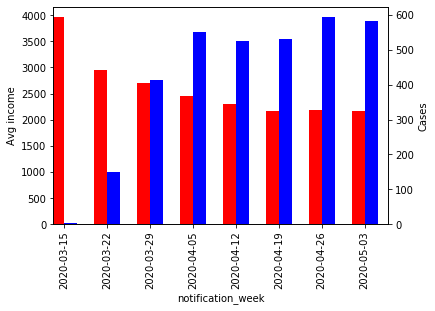

In [52]:
df_exclude_last_two_weeks = df_sp_deaths_income[df_sp_deaths_income['notification_dt'] < pd.to_datetime('2020-05-03')]
df_group = df_exclude_last_two_weeks.groupby('notification_week').agg({'avg_income': 'median', 'notification_week': 'count'}).round(0)

fig = plt.figure() 

ax = fig.add_subplot(111)
ax2 = ax.twinx() 

width = 0.3
df_group.avg_income.plot(kind='bar', color='red', ax=ax, width=width, position=1)
df_group.notification_week.plot(kind='bar', color='blue', ax=ax2, width=width, position=0)

ax.set_ylabel('Avg income')
ax2.set_ylabel('Cases')

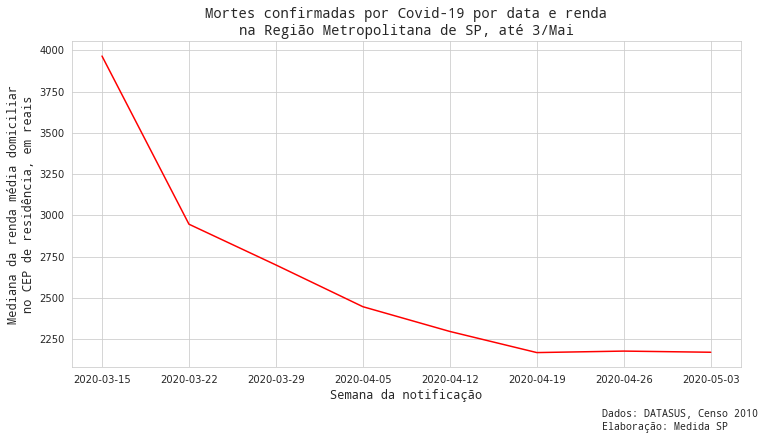

In [54]:
df_exclude_last_two_weeks = df_sp_deaths_income[df_sp_deaths_income['notification_dt'] < pd.to_datetime('2020-05-03')]
df_group = df_exclude_last_two_weeks.groupby('notification_week').agg({'avg_income': 'median'}).round(0)
df_group.reset_index(inplace=True)

x = df_group.notification_week
y = df_group.avg_income

fig, ax = plt.subplots(nrows=1, figsize=(12,6))
sns.set_style("whitegrid")

ax = sns.lineplot(x, y, ax=ax, color='red')
font = {'fontname':'Noto Mono'}
ax.set_title('Mortes confirmadas por Covid-19 por data e renda\nna Região Metropolitana de SP, até 3/Mai', fontname= 'Noto Mono', weight='bold', size=14)
ax.set_xlabel('Semana da notificação', **font, size=12)
ax.set_ylabel('Mediana da renda média domiciliar\nno CEP de residência, em reais', **font, size=12)
ax.text(5.75, 1700, 'Dados: DATASUS, Censo 2010 \nElaboração: Medida SP', size=10, **font)
fig.savefig('exported/mortes_covid_data.png', dpi=300, bbox_inches='tight')
for p in ax.patches:
    ax.annotate(str(p.get_height()) + '%', (p.get_x() + 0.055, (p.get_height() * 1.015) - 3.065), color='white', **font)

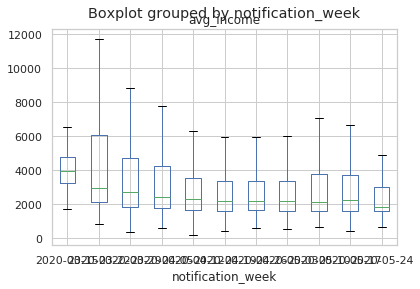

In [221]:
df_sp_deaths_income.boxplot('avg_income', showfliers=False, by='notification_week')

## Age and income

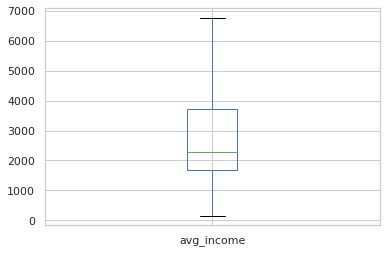

In [222]:
df_sp_deaths_income.boxplot('avg_income', showfliers=False)

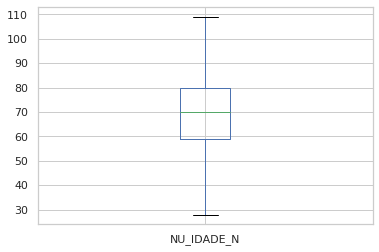

In [223]:
df_sp_deaths_income.boxplot('NU_IDADE_N', showfliers=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f84d754ba20>]],
      dtype=object)

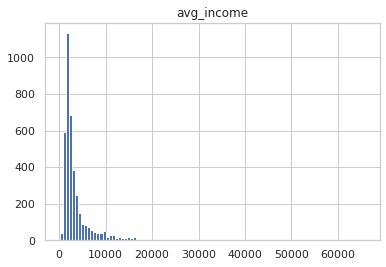

In [224]:
df_sp_deaths_income[['avg_income']].hist(bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f84d797d278>]],
      dtype=object)

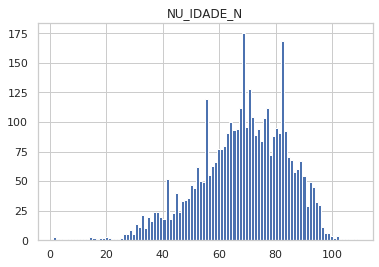

In [225]:
df_sp_deaths_income[['NU_IDADE_N']].hist(bins=100)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


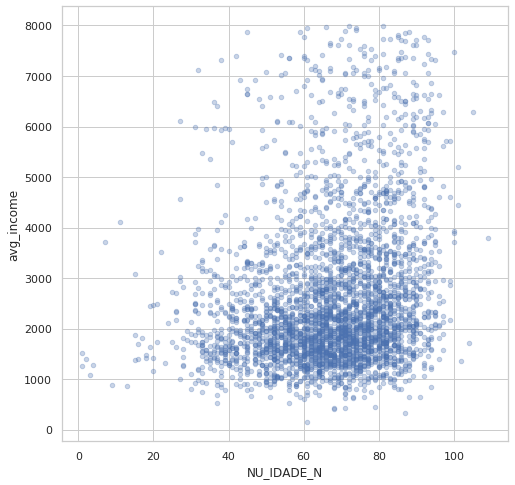

In [226]:
df_sp_deaths_income[(df_sp_deaths_income.avg_income < 8000)].plot.scatter(x='NU_IDADE_N', y='avg_income', figsize=(8,8), alpha=0.3)

In [204]:
age_deaths = df_sp_deaths_income
scipy.stats.pearsonr(age_deaths.NU_IDADE_N, age_deaths.avg_income)

(0.22074989363053335, 6.773567683017204e-45)

### Binning the data

In [26]:
df_sp_deaths_income['age_quant'] = pd.cut(df_sp_deaths_income['NU_IDADE_N'],
                                          bins=age_bins,
                                          include_lowest=True,
                                          labels=age_labels
                                         )
df_sp_deaths_income['income_quant'] = pd.cut(df_sp_deaths_income['avg_income'],
                                             bins=income_bins,
                                             include_lowest=True,
                                             labels=income_labels
                                            )

In [235]:
result = df_sp_deaths_income.groupby(['income_quant', 'age_quant']).size().unstack()

### Save to file

In [151]:
result.to_csv('exported/sp_rmsp_deaths_income_age_bins_jenks.csv')

### Read from file

In [30]:
result = pd.read_csv('exported/sp_rmsp_deaths_income_age_bins_jenks.csv')
result = result.set_index('income_quant')
result = result.astype(float)

Text(0.5, 1.0, 'Covid-19 Deaths by Age Bin')

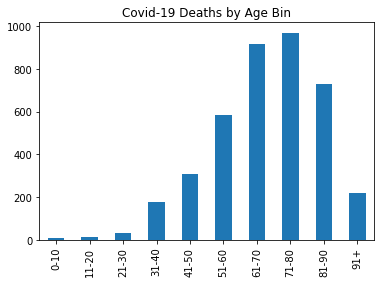

In [31]:
result.sum().plot.bar().set_title('Covid-19 Deaths by Age Bin')

Text(0.5, 1.0, 'Population by Age Bin')

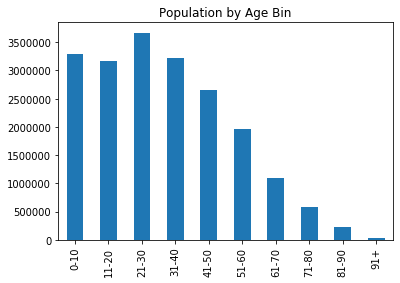

In [32]:
result_pop.sum().plot.bar().set_title('Population by Age Bin')

Text(0.5, 1.0, 'Covid-19 Deaths by Income Bin')

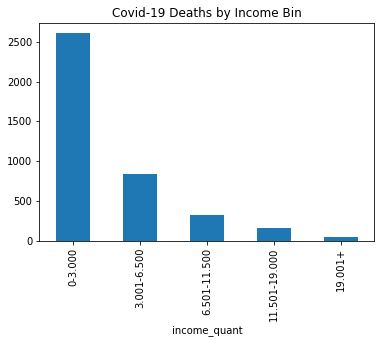

In [33]:
result.transpose().sum().plot.bar().set_title('Covid-19 Deaths by Income Bin')

Text(0.5, 1.0, 'Population by Income Bin')

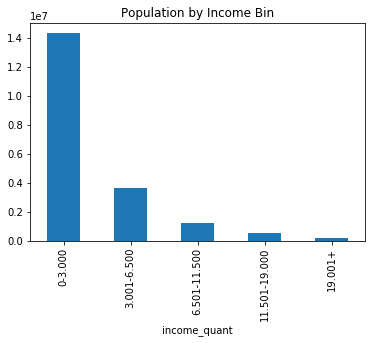

In [34]:
result_pop.transpose().sum().plot.bar().set_title('Population by Income Bin')

### Covid-19 Deaths Heatmap

We use a heatmap here since the scatterplot was too difficult to read because of point density.

In [35]:
print(df_sp_deaths_geo.DT_NOTIFIC.min(), df_sp_deaths_geo.DT_NOTIFIC.max())

2020-03-12 2020-05-18


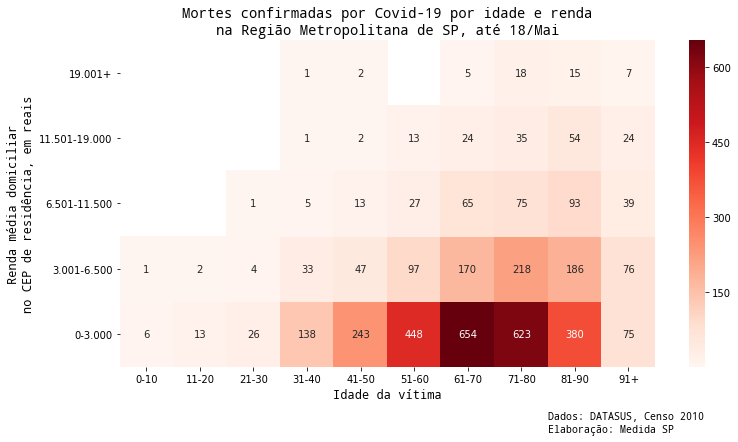

In [49]:
fig, ax = plt.subplots(nrows=1, figsize=(12,6))

ax = sns.heatmap(result, annot=True, fmt="g", cmap='Reds', ax=ax)
ax.invert_yaxis()
font = {'fontname':'Noto Mono'}
ax.set_title('Mortes confirmadas por Covid-19 por idade e renda\nna Região Metropolitana de SP, até 18/Mai', fontname= 'Noto Mono', weight='bold', size=14)
ax.set_xlabel('Idade da vítima', **font, size=12)
ax.set_ylabel('Renda média domiciliar\nno CEP de residência, em reais', **font, size=12)
ax.text(8, -1, 'Dados: DATASUS, Censo 2010 \nElaboração: Medida SP', size=10, **font)
fig.savefig('exported/mortes_covid.png', dpi=300, bbox_inches='tight')

Text(84.5, 0.5, 'Average Income in Neighborhood of Residence')

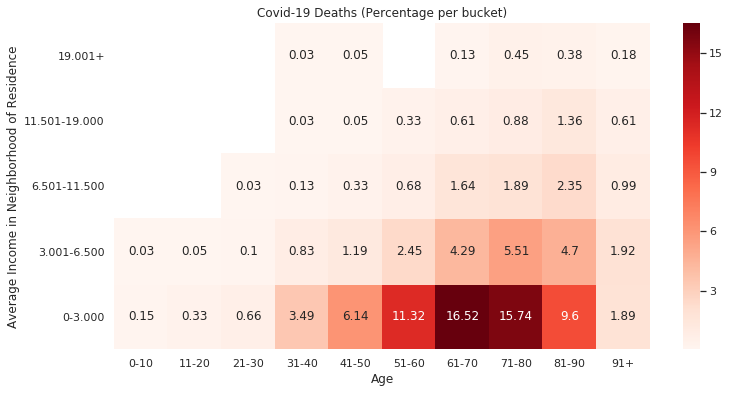

In [218]:
result_pct = (result / result.sum().sum()).round(4).multiply(100)

fig, ax = plt.subplots(nrows=1, figsize=(12,6))

ax = sns.heatmap(result_pct, annot=True, fmt="g", cmap='Reds', ax=ax)
ax.invert_yaxis()
ax.set_title('Covid-19 Deaths (Percentage per bucket)')
ax.set_xlabel('Age')
ax.set_ylabel('Average Income in Neighborhood of Residence')

## Compare to population

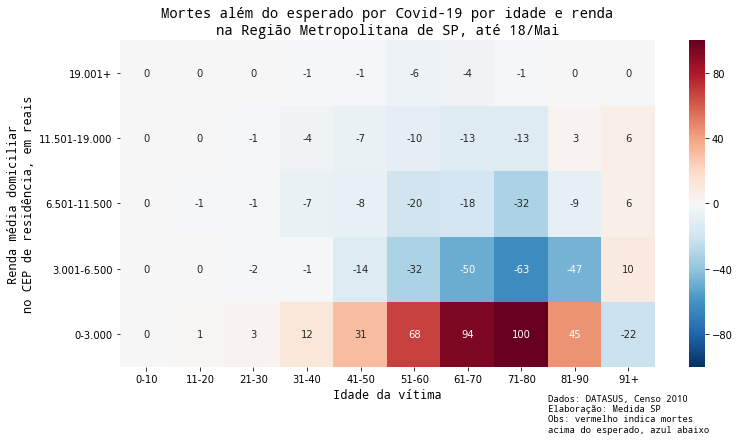

In [50]:
expected_deaths = result_pop.copy()
delta = expected_deaths.copy()
for col in expected_deaths.columns.values:
    expected_deaths[[col]] = (expected_deaths[[col]] / expected_deaths[[col]].sum()).round(2)
    total_deaths = result[[col]].sum().sum()
    expected_deaths[[col]] = expected_deaths[[col]].multiply(total_deaths).round(0)
    delta[[col]] = result[[col]].fillna(0) - expected_deaths[[col]]

fig, ax = plt.subplots(nrows=1, figsize=(12,6))

# note: vmax and vmin values were set after looking at actual values
ax = sns.heatmap(delta, annot=True, fmt="g", cmap='RdBu_r', ax=ax, vmin=-100, vmax=100)
ax.invert_yaxis()
font = {'fontname':'Noto Mono'}
ax.set_title('Mortes além do esperado por Covid-19 por idade e renda\nna Região Metropolitana de SP, até 18/Mai', fontname= 'Noto Mono', weight='bold', size=14)
ax.set_xlabel('Idade da vítima', **font, size=12)
ax.set_ylabel('Renda média domiciliar\nno CEP de residência, em reais', **font, size=12)
ax.text(8, -1, 'Dados: DATASUS, Censo 2010 \nElaboração: Medida SP\nObs: vermelho indica mortes\nacima do esperado, azul abaixo', size=9, **font)
fig.savefig('exported/mortes_esperado_covid.png', dpi=300, bbox_inches='tight')

Text(50.99999999999999, 0.5, 'Average Income in Neighborhood of Residence')

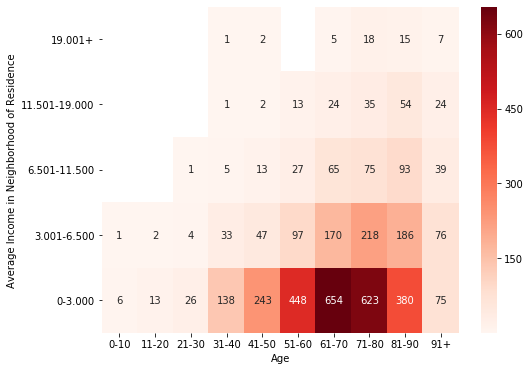

In [195]:
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax = sns.heatmap(result, annot=True, fmt="g", cmap='Reds', ax=ax)
ax.invert_yaxis()
ax.set_xlabel('Age')
ax.set_ylabel('Average Income in Neighborhood of Residence')

Text(50.99999999999999, 0.5, 'Average Income in Neighborhood of Residence')

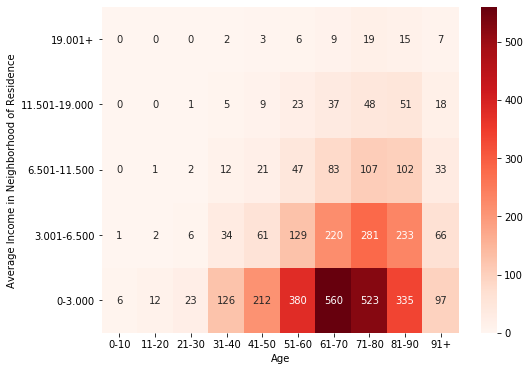

In [194]:
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax = sns.heatmap(expected_deaths, annot=True, fmt="g", cmap='Reds', ax=ax)
ax.invert_yaxis()
ax.set_xlabel('Age')
ax.set_ylabel('Average Income in Neighborhood of Residence')

Text(50.99999999999999, 0.5, 'Average Income in Neighborhood of Residence')

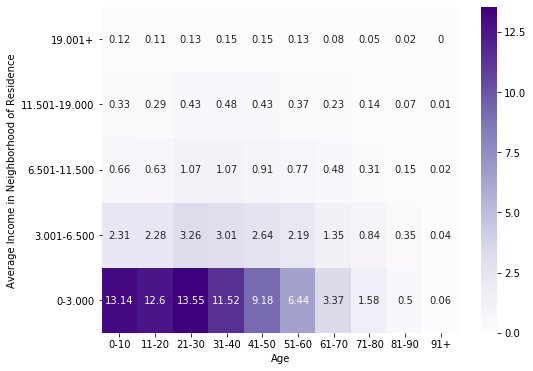

In [193]:
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax = sns.heatmap(result_pop_pct, annot=True, fmt="g", cmap='Purples', ax=ax)
ax.invert_yaxis()
ax.set_xlabel('Age')
ax.set_ylabel('Average Income in Neighborhood of Residence')

### Compute chi-square tests for each age column

In [298]:
for col in result.columns.values:
    chi = scipy.stats.chisquare(result[[col]].fillna(0))
    print(col, chi)

0-10 Power_divergenceResult(statistic=array([19.42857143]), pvalue=array([0.0006473]))
11-20 Power_divergenceResult(statistic=array([42.66666667]), pvalue=array([1.2134017e-08]))
21-30 Power_divergenceResult(statistic=array([80.77419355]), pvalue=array([1.19391028e-16]))
31-40 Power_divergenceResult(statistic=array([388.29213483]), pvalue=array([9.41443024e-83]))
41-50 Power_divergenceResult(statistic=array([693.57003257]), pvalue=array([8.59987002e-149]))
51-60 Power_divergenceResult(statistic=array([1218.51282051]), pvalue=array([1.54459744e-262]))
61-70 Power_divergenceResult(statistic=array([1595.30065359]), pvalue=array([0.]))
71-80 Power_divergenceResult(statistic=array([1315.96904025]), pvalue=array([1.14770149e-283]))
81-90 Power_divergenceResult(statistic=array([582.34340659]), pvalue=array([1.02653586e-124]))
91+ Power_divergenceResult(statistic=array([85.49321267]), pvalue=array([1.1921451e-17]))


## Statistics about race

### Census population data for São Paulo Metropolitan Region by race

In [414]:
# https://sidra.ibge.gov.br/Tabela/3175
df_sp_metro_race = pd.read_excel('data/ibge/sidra_tabela3175.xlsx', skiprows=4, skipfooter=1)
display(df_sp_metro_race)
df_sp_metro_race = df_sp_metro_race[1:2].transpose()[4:]
df_sp_metro_race.rename(columns={df_sp_metro_race.columns[0]: "População"}, inplace=True)
df_sp_metro_race.reset_index(inplace=True)
df_sp_metro_race.rename(columns={df_sp_metro_race.columns[0]: "race"}, inplace=True)
df_sp_metro_race

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Total,Branca,Preta,Amarela,Parda,Indígena,Sem declaração
0,NaN,NaN,NaN,Total,Total,Total,Total,Total,Total,Total
1,São Paulo (SP),Total,Total,19683975,11584499,1268104,355560,6453193,21089,1530


,race,População
0,Branca,11584499
1,Preta,1268104
2,Amarela,355560
3,Parda,6453193
4,Indígena,21089
5,Sem declaração,1530


In [619]:
df_sp_metro_race['non_white'] = np.where(df_sp_metro_race.race == 'Branca', 'Branca', np.where(df_sp_metro_race.race == 'Sem declaração', 'Não informada', 'Não branca'))

In [620]:
df_sp_metro_race

,race,População,non_white
0,Branca,11584499,Branca
1,Preta,1268104,Não branca
2,Amarela,355560,Não branca
3,Parda,6453193,Não branca
4,Indígena,21089,Não branca
5,Sem declaração,1530,Não informada


In [621]:
df_sp_metro_race_pct = df_sp_metro_race.groupby('non_white')[['População']].sum() / df_sp_metro_race['População'].sum()
df_sp_metro_race_pct

,População
non_white,
Branca,0.588524
Não branca,0.411398
Não informada,0.000078


## Covid Deaths by Race

In [634]:
df_srag['race'] = df_srag['CS_RACA'].replace({1: 'Branca', 2: 'Preta', 3: 'Amarela', 4: 'Parda', 5: 'Indígena', 9: 'Não informada'})
df_srag['race'] = df_srag['race'].fillna('Não informada')

In [635]:
df_srag['non_white'] = np.where(df_srag.CS_RACA.isna(), 'Não informada', np.where(df_srag.CS_RACA == 9, 'Não informada', np.where(df_srag.CS_RACA == 1, 'Branca', 'Não branca')))

In [636]:
sp_metro_set_cens_income_age[sp_metro_set_cens_income_age.NM_MUNICIP == 'SÃO PAULO'].head()
sp_metro_set_cens_income_age['city_name'] = sp_metro_set_cens_income_age['NM_MUNICIP'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

In [638]:
df_rmsp_covid_deaths = (
    df_srag[
        (df_srag.SG_UF == 'SP')
        & (df_srag.CLASSI_FIN == 5)
        & (df_srag.ID_MUNICIP.isin(sp_metro_set_cens_income_age['city_name']))
        & (df_srag.EVOLUCAO == 2)
    ]
)

In [639]:
len(df_rmsp_covid_deaths)

4358

In [642]:
df_rmsp_covid_deaths_pct = df_rmsp_covid_deaths.groupby('non_white').size() / len(df_rmsp_covid_deaths[df_rmsp_covid_deaths.non_white.notna()])
df_rmsp_covid_deaths_pct = pd.DataFrame(df_rmsp_covid_deaths_pct)
df_rmsp_covid_deaths_pct.rename(columns={df_rmsp_covid_deaths_pct.columns[0]: "Mortes"}, inplace=True)
df_rmsp_covid_deaths_pct

,Mortes
non_white,
Branca,0.402478
Não branca,0.261129
Não informada,0.336393


In [643]:
df_sp_metro_race

,race,População,non_white
0,Branca,11584499,Branca
1,Preta,1268104,Não branca
2,Amarela,355560,Não branca
3,Parda,6453193,Não branca
4,Indígena,21089,Não branca
5,Sem declaração,1530,Não informada


In [644]:
df_sp_metro_race_pct = df_sp_metro_race.groupby('non_white')[['População']].sum() / df_sp_metro_race['População'].sum()
df_sp_metro_race_pct

,População
non_white,
Branca,0.588524
Não branca,0.411398
Não informada,0.000078


In [645]:
deaths_race_table = df_sp_metro_race_pct.merge(df_rmsp_covid_deaths_pct, left_index=True, right_index=True)
deaths_race_table = deaths_race_table.multiply(100).round(1) 

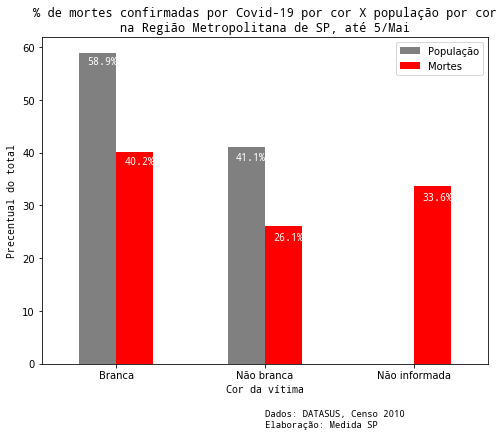

In [646]:
fig, ax = plt.subplots(nrows=1, figsize=(8,6))

ax = deaths_race_table.plot.bar(ax=ax, rot=0, color=['gray', 'red'])
font = {'fontname':'Noto Mono'}
ax.set_title('% de mortes confirmadas por Covid-19 por cor X população por cor\nna Região Metropolitana de SP, até 18/Mai', fontname= 'Noto Mono', weight='bold')
ax.set_xlabel('Cor da vítima', **font)
ax.set_ylabel('Precentual do total', **font)
for p in ax.patches:
    ax.annotate(str(p.get_height()) + '%', (p.get_x() + 0.055, (p.get_height() * 1.015) - 3.065), color='white', **font)
ax.text(1, -12, 'Dados: DATASUS, Censo 2010 \nElaboração: Medida SP', fontsize=9, **font)
fig.savefig('exported/mortes_raca_covid.png', dpi=300, bbox_inches='tight')

So much missing data that we can't analyze it...

## By color / race

In [647]:
df_rmsp_covid_deaths_pct = df_rmsp_covid_deaths.groupby('race').size() / len(df_rmsp_covid_deaths[df_rmsp_covid_deaths.race.notna()])
df_rmsp_covid_deaths_pct = pd.DataFrame(df_rmsp_covid_deaths_pct)
df_rmsp_covid_deaths_pct.rename(columns={df_rmsp_covid_deaths_pct.columns[0]: "Mortes"}, inplace=True)
df_rmsp_covid_deaths_pct

,Mortes
race,
Amarela,0.016751
Branca,0.402478
Indígena,0.000688
Não informada,0.336393
Parda,0.189766
Preta,0.053924


In [648]:
df_sp_metro_races_pct = df_sp_metro_race.groupby('race')[['População']].sum() / df_sp_metro_race['População'].sum()
df_sp_metro_races_pct

,População
race,
Amarela,0.018063
Branca,0.588524
Indígena,0.001071
Parda,0.327840
Preta,0.064423
Sem declaração,0.000078


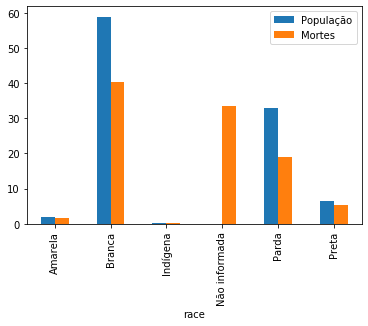

In [651]:
deaths_race_table = df_sp_metro_races_pct.merge(df_rmsp_covid_deaths_pct, left_index=True, right_index=True, how='right')
deaths_race_table = deaths_race_table.multiply(100).round(1) 
deaths_race_table.plot.bar()